# Make QU fitting plots for tadpole paper
## A. Ordog, Nov. 2023
### Updated Mar. 2024 to use new maps after correction to Stokes U calibration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import ICRS    
from astropy.coordinates import Galactic 
from astropy.coordinates import SkyCoord 
import json
from RMtools_1D.do_RMsynth_1D import run_rmsynth
from RMtools_1D.do_RMclean_1D import run_rmclean
import matplotlib.colors as mplc

## Set save_plots to True to save figures (will overwrite old ones unless directory changed)

In [37]:
save_plots = False
# Old files:
#directory = '/srv/data/chime/tadpole_cutout/QU_fitting_results/'
# New files:
directory = '/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_results/'

## Read in coordinates and categories (head, tail, off)

In [42]:
#coords = np.genfromtxt(directory+'tadpole_points_extra.dat', delimiter=' ')
#coords = np.genfromtxt(directory+'tadpole_paper_points.dat', delimiter=' ')
coords = np.genfromtxt(directory+'tadpole_points.dat', delimiter=' ')
lon = coords[:,0]
lat = coords[:,1]
cat = coords[:,2]

filename = []
for i in range(0,len(lon)):
    filename.append('lon'+"{:.1f}".format(lon[i])+'_lat'+"{:.1f}".format(lat[i]))
    
idxh = np.where(cat==1)
idxt = np.where(cat==2)
idxo = np.where(cat==3)

## Read in CHIME data for tadpole

In [4]:
# Old files:
#hduQ = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/Q_400_729_Oct2023_tadpole_gal.fits')
#hduU = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/U_400_729_Oct2023_tadpole_gal.fits')
#hduI = fits.open('/srv/data/chime/tadpole_cutout/IQU_400_729/I_400_729_Oct2023_tadpole_gal.fits')
# New files:
hduQ = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/Q_400_729_Mar2024_tadpole_gal.fits')
hduU = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/U_400_729_Mar2024_tadpole_gal.fits')
hduI = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/IQUV_400_729/I_400_729_Oct2023_tadpole_gal.fits')

# Old files:
#hdu_PA0 = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU_per_I/dirty_polAngle0Fit_deg.fits')
#hdu_FDF_dirty_p = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU_per_I/FDF_tot_dirty.fits')
#hdu_FDF_clean_p = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU_per_I/FDF_clean_tot.fits')
#hdu_FDF_dirty_pI = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/FDF_tot_dirty.fits')
#hdu_FDF_clean_pI = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/clean_200mJy/FDF_clean_tot.fits')
# New files:
hdu_PA0 = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/QU_per_I/dirty_polAngle0Fit_deg.fits')
hdu_FDF_dirty_p = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/QU_per_I/FDF_tot_dirty.fits')
hdu_FDF_clean_p = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/QU_per_I/FDF_clean_tot.fits')
hdu_FDF_dirty_pI = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_tot_dirty.fits')
hdu_FDF_clean_pI = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/FDF_clean_tot.fits')

# Old files:
#hdu_peak_p = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU_per_I/dirty_phiPeakPIfit_rm2.fits')
#hdu_peak_pI = fits.open('/srv/data/chime/tadpole_cutout/RMsynth_400_729/QU/dirty_phiPeakPIfit_rm2.fits')
# New files:
hdu_peak_p = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/QU_per_I/dirty_phiPeakPIfit_rm2.fits')
hdu_peak_pI = fits.open('/srv/data/chime/tadpole_cutout_Mar2024/RMsynth_400_729/dirty_phiPeakPIfit_rm2.fits')

Q = hduQ[0].data
U = hduU[0].data
I = hduI[0].data
PA0 = hdu_PA0[0].data
PA = 0.5*np.arctan2(hduU[0].data,hduQ[0].data)*180/np.pi
PA[PA<0] = PA[PA<0]+180

FDF_dirty_p = hdu_FDF_dirty_p[0].data
FDF_clean_p = hdu_FDF_clean_p[0].data
FDF_dirty_pI = hdu_FDF_dirty_pI[0].data
FDF_clean_pI = hdu_FDF_clean_pI[0].data

peak_p  = hdu_peak_p[0].data
peak_pI = hdu_peak_pI[0].data

hdr = hduQ[0].header
hdr_FDF = hdu_FDF_clean_p[0].header

hdr2D = hdr.copy()
hdr2D['NAXIS'] = 2
hdr2D['WCSAXES'] = 2
for card in hdr.cards:
    try:
        if card[0][5] == '3':
            del hdr2D[card[0]]
    except:
        pass
    
freq = WCS(hdr).all_pix2world(0,0,range(Q.shape[0]),0)[2]
print(freq[0],freq[-1])
FD_ax = WCS(hdr_FDF).all_pix2world(0,0,range(FDF_clean_p.shape[0]),0)[2]
print(FD_ax[0],FD_ax[-1])

729687500.0 400390625.0
-200.0 200.0


## Compare fractional pol and polarized intensity peak FD maps

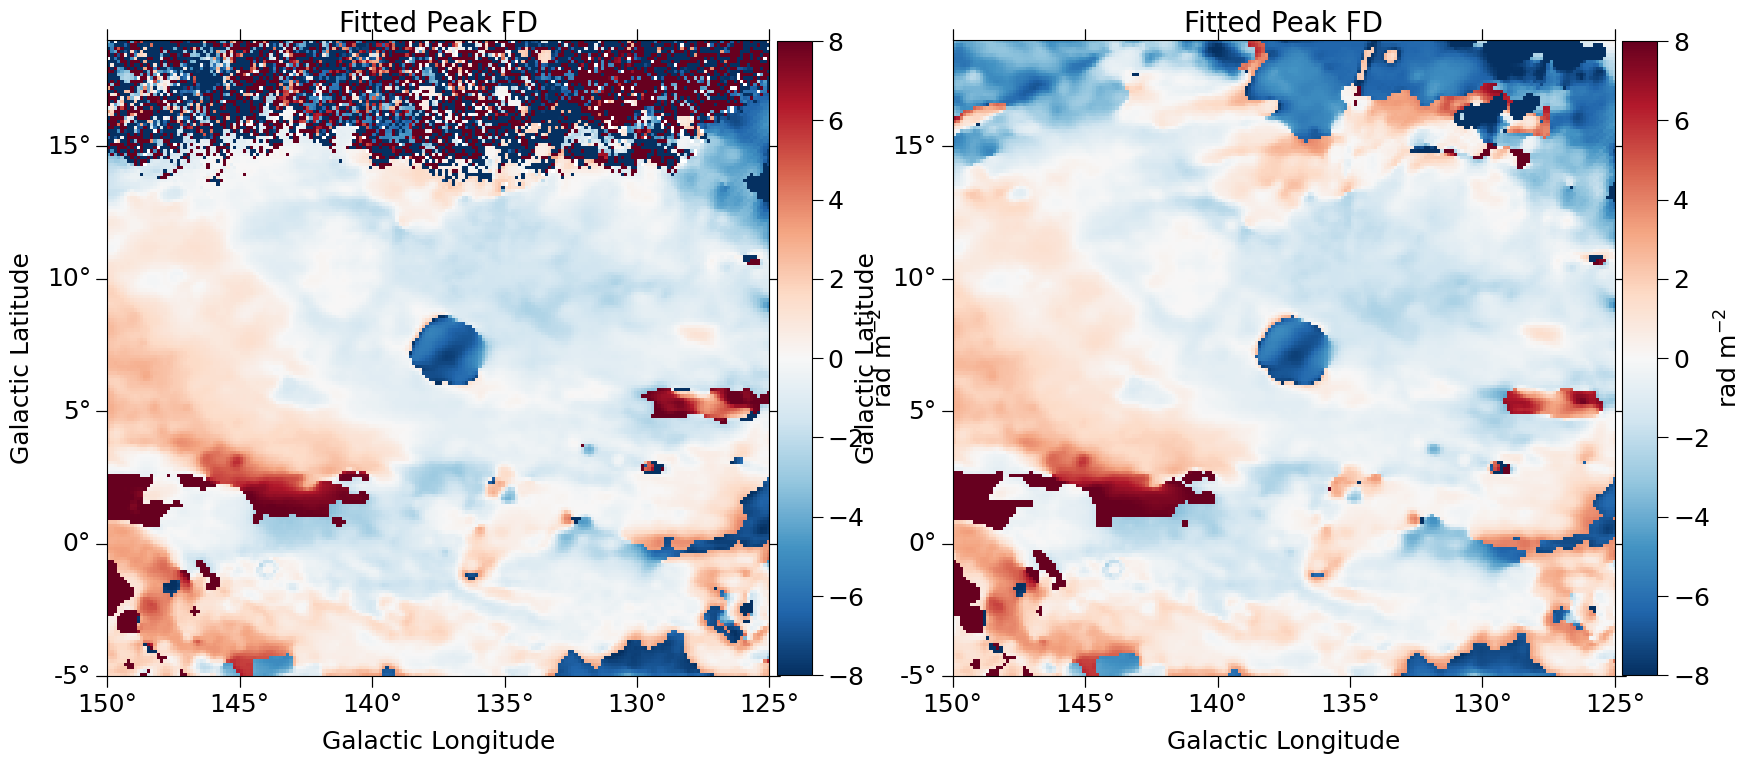

In [5]:
fig = plt.figure(figsize=(20,12))
fs = 18
frac = 0.05; pad = 0.01; aspect=18

llim = [150,125]
blim = [-5,19]
c = SkyCoord(llim, blim, frame=Galactic, unit="deg")

ax1  = fig.add_subplot(121, projection=WCS(hdr2D).celestial)
im1 = ax1.imshow(peak_p,origin='lower',vmin=-8, vmax=8,cmap='RdBu_r')
cbar= fig.colorbar(im1,ax=ax1,orientation='vertical',fraction=frac,pad=pad,aspect=aspect)
cbar.set_label('rad m$^{-2}$', fontsize=fs)
cbar.ax.tick_params(axis='y', which='both',labelsize=fs)

ax2  = fig.add_subplot(122, projection=WCS(hdr2D).celestial)
im2 = ax2.imshow(peak_pI,origin='lower',vmin=-8, vmax=8,cmap='RdBu_r')
cbar= fig.colorbar(im2,ax=ax2,orientation='vertical',fraction=frac,pad=pad,aspect=aspect)
cbar.set_label('rad m$^{-2}$', fontsize=fs)
cbar.ax.tick_params(axis='y', which='both',labelsize=fs)

for ax in [ax1,ax2]:
    ax.set_xlim(WCS(hdr2D).world_to_pixel(c)[0])
    ax.set_ylim(WCS(hdr2D).world_to_pixel(c)[1])
    ax.tick_params(axis='both', labelsize=fs)
    ax.set_ylabel('  ',fontsize=fs)
    ax.set_xlabel('  ',fontsize=fs)
    ax.set_xlabel('Galactic Longitude',fontsize=fs)
    ax.set_ylabel('Galactic Latitude',fontsize=fs)
    ax.set_title('Fitted Peak FD',fontsize=fs+2)

## Create dictionaries for model statistics and parameters from qufit JSON files

In [23]:
def make_dictionaries():

    models = ['m1','m11','m2','m4']

    stats  = {}
    params = {}

    for model in models:

        # set up dictionary for statistics:
        stats[model] =  {}
        stats[model]['chiSq'] = []
        stats[model]['chiSqRed'] = []
        stats[model]['BIC'] = []
        stats[model]['lnZ'] = []

        # set up dictionary for parameters:
        params[model] = {}
        with open(directory+filename[0]+'_'+model+'_pymultinest.json', 'r') as json_file:
            qu_result = json.load(json_file)
            for parName in qu_result["parNames"]:
                params[model][parName] = []

        for file in filename:
            with open(directory+file+'_'+model+'_pymultinest.json', 'r') as json_file:         
                qu_result = json.load(json_file)

                # Get data for stats:
                stats[model]['chiSq'].append(qu_result["chiSq"])
                stats[model]['chiSqRed'].append(qu_result["chiSqRed"])
                stats[model]['BIC'].append(qu_result["BIC"])
                stats[model]['lnZ'].append(qu_result["ln(EVIDENCE) "])

                # Get data for parameters:
                for parName in qu_result["parNames"]:
                    params[model][parName].append(qu_result["values"][qu_result["parNames"].index(parName)])

        # Make everything into numpy arrays
        stats[model]['chiSq'] = np.array(stats[model]['chiSq'])
        stats[model]['chiSqRed'] = np.array(stats[model]['chiSqRed'])
        stats[model]['BIC'] = np.array(stats[model]['BIC'])
        stats[model]['lnZ'] = np.array(stats[model]['lnZ'])
        with open(directory+filename[0]+'_'+model+'_pymultinest.json', 'r') as json_file:
            qu_result = json.load(json_file)
            for parName in qu_result["parNames"]:
                params[model][parName] = np.array(params[model][parName])
                
    return params, stats

## Sort two-component models by polarized intensity

In [24]:
def sort_by_pol():
    
    print('Sorting by pol fraction...')
    print('')

    for model in ['m11','m4']:

        RM1_old = params[model]['RM1_radm2']; RM1_new = RM1_old.copy()
        RM2_old = params[model]['RM2_radm2']; RM2_new = RM2_old.copy()

        pol1_old = params[model]['fracPol1']; pol1_new = pol1_old.copy()
        pol2_old = params[model]['fracPol2']; pol2_new = pol2_old.copy()

        psi01_old = params[model]['psi01_deg']; psi01_new = psi01_old.copy()
        psi02_old = params[model]['psi02_deg']; psi02_new = psi02_old.copy()

        if model == 'm4':
            sigma1_old = params[model]['sigmaRM1_radm2']; sigma1_new = sigma1_old.copy()
            sigma2_old = params[model]['sigmaRM2_radm2']; sigma2_new = sigma2_old.copy()

        for i in range(0,len(lon)):
            if pol1_old[i] < pol2_old[i]:
                RM1_new[i] = RM2_old[i]
                RM2_new[i] = RM1_old[i]
                pol1_new[i] = pol2_old[i]
                pol2_new[i] = pol1_old[i]
                psi01_new[i] = psi02_old[i]
                psi02_new[i] = psi01_old[i]
                if model == 'm4':
                    sigma1_new[i] = sigma2_old[i]
                    sigma2_new[i] = sigma1_old[i]

        params[model]['RM1_radm2'] = RM1_new
        params[model]['RM2_radm2'] = RM2_new
        params[model]['fracPol1'] = pol1_new
        params[model]['fracPol2'] = pol2_new
        params[model]['psi01_deg'] = psi01_new
        params[model]['psi02_deg'] = psi02_new
        if model == 'm4':
            params[model]['sigmaRM1_radm2'] = sigma1_new
            params[model]['sigmaRM2_radm2'] = sigma2_new

    #for i in range(0,len(lon)):
    #    print(pol1_old[i],pol2_old[i],sigma1_old[i],sigma2_old[i])
    #    print(pol1_new[i],pol2_new[i],sigma1_new[i],sigma2_new[i])
    #    print('')
    
    return params, stats

## Read in QU fitting results

In [43]:
sort_pol = True
params, stats = make_dictionaries()
if sort_pol:
    params, stats = sort_by_pol()
    
print(params.keys())
print(params['m1'].keys())
print(params['m11'].keys())
print(params['m2'].keys())
print(params['m4'].keys())
print('')
print(stats.keys())
print(stats['m1'].keys())
print(stats['m11'].keys())
print(stats['m2'].keys())
print(stats['m4'].keys())

Sorting by pol fraction...

dict_keys(['m1', 'm11', 'm2', 'm4'])
dict_keys(['fracPol', 'psi0_deg', 'RM_radm2'])
dict_keys(['fracPol1', 'fracPol2', 'psi01_deg', 'psi02_deg', 'RM1_radm2', 'RM2_radm2'])
dict_keys(['fracPol', 'psi0_deg', 'RM_radm2', 'sigmaRM_radm2'])
dict_keys(['fracPol1', 'fracPol2', 'psi01_deg', 'psi02_deg', 'RM1_radm2', 'RM2_radm2', 'sigmaRM1_radm2', 'sigmaRM2_radm2'])

dict_keys(['m1', 'm11', 'm2', 'm4'])
dict_keys(['chiSq', 'chiSqRed', 'BIC', 'lnZ'])
dict_keys(['chiSq', 'chiSqRed', 'BIC', 'lnZ'])
dict_keys(['chiSq', 'chiSqRed', 'BIC', 'lnZ'])
dict_keys(['chiSq', 'chiSqRed', 'BIC', 'lnZ'])


## Compare the models using stats

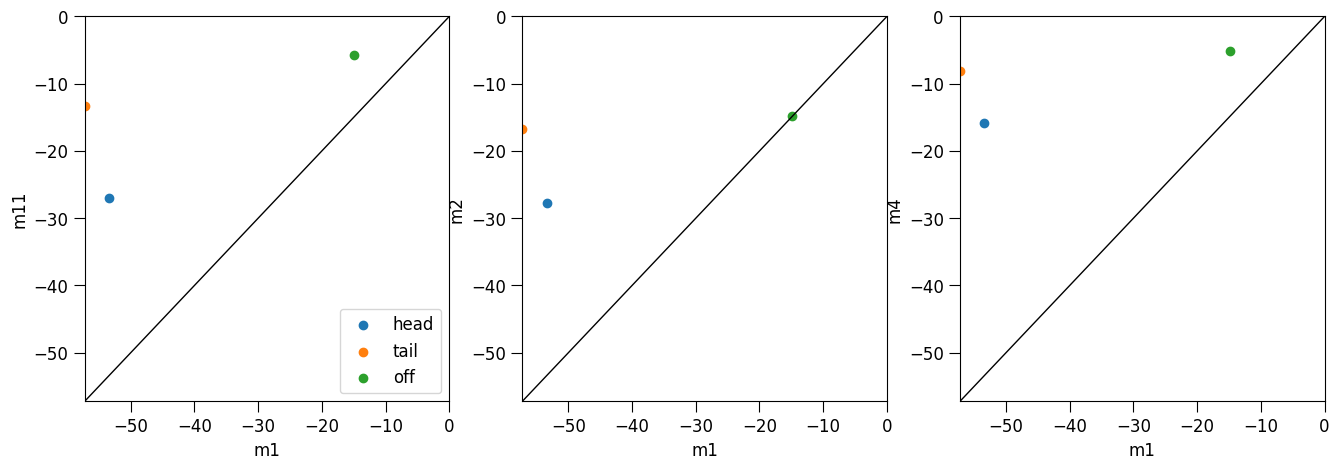

In [40]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

test = 'lnZ'
mx = ['m1','m1','m1']
my = ['m11','m2','m4']

for i in range(0,3):

    ax[i].scatter(stats[mx[i]][test][idxh]/1e3,stats[my[i]][test][idxh]/1e3,label='head')
    ax[i].scatter(stats[mx[i]][test][idxt]/1e3,stats[my[i]][test][idxt]/1e3,label='tail')
    ax[i].scatter(stats[mx[i]][test][idxo]/1e3,stats[my[i]][test][idxo]/1e3,label='off')

    if test == 'lnZ':
        ax[i].set_xlim(min(stats[mx[0]][test])/1e3,0)
        ax[i].set_ylim(min(stats[mx[0]][test])/1e3,0)
    else:
        ax[i].set_xlim(0,max(stats[mx[0]][test])/1e3)
        ax[i].set_ylim(0,max(stats[mx[0]][test])/1e3)
    ax[i].plot([-15e2,15e2],[-15e2,15e2],color='k')
    
    ax[i].set_xlabel(mx[i])
    ax[i].set_ylabel(my[i])

ax[0].legend(loc='lower right')

plt.savefig('/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_plots_Mar112024/lnZ_compare_models_new_3pts.pdf')
plt.savefig('/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_plots_Mar112024/lnZ_compare_models_new_3pts.png')

In [10]:
def P_model(lbsq,P01=0.0,P02=0.0,psi01=0.0,psi02=0.0,
                 phi1=0.0,phi2=0.0,sigma1=0.0,sigma2=0.0):
    
    P1 = P01*np.exp(2j*(np.radians(psi01)+phi1*lbsq)) * np.exp(-2*(sigma1*lbsq)**2)
    P2 = P02*np.exp(2j*(np.radians(psi02)+phi2*lbsq)) * np.exp(-2*(sigma2*lbsq)**2)
    
    P = P1+P2
    
    return P


def calc_P(lbsq,i,j,model,ii,do_PI=False,I_use=None):
    
    P01=0.0; P02=0.0
    psi01=0.0; psi02=0.0,
    phi1=0.0; phi2=0.0
    sigma1=0.0; sigma2=0.0
    
    if model in ['m1','m2']:
        P01    = params[model]['fracPol'][ii]
        phi1   = params[model]['RM_radm2'][ii]
        psi01  = params[model]['psi0_deg'][ii]
        if model == 'm2':
            sigma1  = params[model]['sigmaRM_radm2'][ii]
    if model in ['m11','m4']:
        P01    = params[model]['fracPol1'][ii]
        P02    = params[model]['fracPol2'][ii]
        phi1   = params[model]['RM1_radm2'][ii]
        phi2   = params[model]['RM2_radm2'][ii]
        psi01  = params[model]['psi01_deg'][ii]
        psi02  = params[model]['psi02_deg'][ii]
        if model == 'm4':
            sigma1  = params[model]['sigmaRM1_radm2'][ii]
            sigma2  = params[model]['sigmaRM2_radm2'][ii]
            
    P = P_model(lbsq,P01=P01,P02=P02,
                     psi01=psi01,psi02=psi02,
                     phi1=phi1,phi2=phi2,
                     sigma1=sigma1,sigma2=sigma2)
    if do_PI:
        P = P*I_use[:,j,i]
    
    return P


def sim_rmsynth_clean(freq,P,error=0.01,dPhi_radm2=0.1,phiMax_radm2=200,clean=0.02):

    rmsynth_out = run_rmsynth([freq, P.real, P.imag,
                               np.ones_like(P.real)*error, np.ones_like(P.imag)*error],
                               dPhi_radm2=dPhi_radm2,phiMax_radm2=phiMax_radm2)

    FD_sim  = rmsynth_out[1]['phiArr_radm2']
    FDF_sim = np.abs(rmsynth_out[1]['dirtyFDF'])
    
    clean_out = run_rmclean(rmsynth_out[0], rmsynth_out[1], clean)
    
    FD_clean_sim  = clean_out[1]['phiArr_radm2']
    FDF_clean_sim = np.abs(clean_out[1]['cleanFDF'])

    return FD_sim, FDF_sim, FD_clean_sim, FDF_clean_sim

In [11]:
def plot_QU_fit_result_paper(i1,i2,i3,models1,models2,models3,linestyles,colors,labels,legend=True):

    #fig = plt.figure(figsize=(20,8))
    fig, [[ax1Q,ax2Q,ax3Q],
          [ax1U,ax2U,ax3U],
          [ax1P,ax2P,ax3P]] = plt.subplots(3,3, sharex=True,figsize=(18,10))
    fig.subplots_adjust(hspace=0,wspace=0,left=0.08,right=0.98,bottom=0.08,top=0.95)
    #fig.subplots_adjust(wspace=0)
    fs = 18

    lbd2 = (3e8/freq)**2
    lbd2_smooth = np.linspace(0,5,1000)

    c = SkyCoord(lon[i1], lat[i1], frame=Galactic, unit="deg")
    pixels = WCS(hdr2D).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))    
    ax1Q.scatter(lbd2,Q[:,j,i]/I[:,j,i],color='k',s=5)
    ax1U.scatter(lbd2,U[:,j,i]/I[:,j,i],color='k',s=5)
    ax1P.scatter(lbd2,np.sqrt(U[:,j,i]**2+Q[:,j,i]**2)/I[:,j,i],color='k',s=5)
    ii = 0
    for model in models1:
        P = calc_P(lbd2_smooth,i,j,model,i1)
        ax1Q.plot(lbd2_smooth,P.real,linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ax1U.plot(lbd2_smooth,P.imag,linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ax1P.plot(lbd2_smooth,abs(P),linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ii = ii+1

    c = SkyCoord(lon[i2], lat[i2], frame=Galactic, unit="deg")
    pixels = WCS(hdr2D).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))    
    ax2Q.scatter(lbd2,Q[:,j,i]/I[:,j,i],color='k',s=5)
    ax2U.scatter(lbd2,U[:,j,i]/I[:,j,i],color='k',s=5)
    ax2P.scatter(lbd2,np.sqrt(U[:,j,i]**2+Q[:,j,i]**2)/I[:,j,i],color='k',s=5)
    ii = 0
    for model in models2:
        P = calc_P(lbd2_smooth,i,j,model,i2)
        ax2Q.plot(lbd2_smooth,P.real,linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ax2U.plot(lbd2_smooth,P.imag,linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ax2P.plot(lbd2_smooth,abs(P),linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ii = ii+1

    c = SkyCoord(lon[i3], lat[i3], frame=Galactic, unit="deg")
    pixels = WCS(hdr2D).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))    
    ax3Q.scatter(lbd2,Q[:,j,i]/I[:,j,i],color='k',s=5)
    ax3U.scatter(lbd2,U[:,j,i]/I[:,j,i],color='k',s=5)
    ax3P.scatter(lbd2,np.sqrt(U[:,j,i]**2+Q[:,j,i]**2)/I[:,j,i],color='k',s=5)
    ii = 0
    for model in models3:
        P = calc_P(lbd2_smooth,i,j,model,i3)
        ax3Q.plot(lbd2_smooth,P.real,linewidth=2,color=colors[ii],linestyle=linestyles[ii],label=labels[ii])
        ax3U.plot(lbd2_smooth,P.imag,linewidth=2,color=colors[ii],linestyle=linestyles[ii])
        ax3P.plot(lbd2_smooth,abs(P),linewidth=2,color=colors[ii],linestyle=linestyles[ii])   
        ii = ii+1
        
    panels = [r'$(a)$',r'$(d)$',r'$(g)$',r'$(b)$',r'$(e)$',r'$(h)$',r'$(c)$',r'$(f)$',r'$(i)$']
    plocs  = [0.48,0.48,0.54,0.48,0.48,0.54,0.48,0.48,0.54]
    ii = 0    
    for ax in [ax1Q,ax1U,ax1P,ax2Q,ax2U,ax2P,ax3Q,ax3U,ax3P]:
        ax.set_ylim(-0.6,0.6)
        ax.set_xlim(0.0,0.8)
        ax.text(0.75,plocs[ii],panels[ii], fontsize=fs-2, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'k'}, ha='center', va='center')
        ii = ii + 1
    for ax in [ax2Q,ax2U,ax3Q,ax3U]:
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)
    for ax in [ax2P,ax3P]:
        ax.tick_params(left = False, right = False , labelleft = False)
    
    if legend:
        legend = ax3Q.legend(fontsize=fs,loc='lower left')
        legend.get_frame().set_alpha(0)
        legend.get_frame().set_facecolor((0, 0, 0, 0))
    
    ax1Q.set_ylabel(r'Re($\tilde{p}$) ($Q/I$)',fontsize=fs)
    ax1U.set_ylabel(r'Im($\tilde{p}$) ($U/I$)',fontsize=fs)
    
    for ax in [ax1Q,ax1U]:
        ax.tick_params(axis = 'y', which = 'both', labelsize = fs)
        ax.set_yticks([-0.5,0,0.5])
        ax.set_yticks(np.arange(-0.6,0.6,0.1), minor = True)
    for ax in [ax3Q,ax3U]:
        ax.tick_params(axis = 'y', which = 'both', labelsize = fs,right=True,left=False)
        ax.set_yticks([-0.5,0,0.5])
        ax.set_yticks(np.arange(-0.6,0.6,0.1), minor = True)
    
    ax1P.tick_params(axis = 'y', which = 'both', labelsize = fs)
    ax1P.set_yticks([0,0.25,0.5])
    ax1P.set_yticks(np.arange(0,0.6,0.05), minor = True)
    
    ax3P.tick_params(axis = 'y', which = 'both', labelsize = fs,right=True,left=False)
    ax3P.set_yticks([0,0.25,0.5])
    ax3P.set_yticks(np.arange(0,0.6,0.05), minor = True)
    
    for ax in [ax1P,ax2P]:
        #ax.tick_params(bottom=False, top=True, left=True, right=True)
        ax.tick_params(axis = 'x', which = 'both', labelsize = fs)
        ax.set_xticks([0,0.2,0.4,0.6,0.8])
        ax.set_xticks(np.arange(0,0.8,0.05), minor = True)
    ax3P.tick_params(axis = 'x', which = 'both', labelsize = fs)
    ax3P.set_xticks([0,0.2,0.4,0.6,0.8])
    ax3P.set_xticks(np.arange(0,0.85,0.05), minor = True)
    for ax in [ax1Q,ax2Q,ax3Q]:
        #ax.tick_params(bottom=False, top=True, left=True, right=True)
        ax.tick_params(axis = 'x', which = 'both', labelsize = fs,top=True)
        ax.set_xticks([0,0.2,0.4,0.6])
        ax.set_xticks(np.arange(0,0.8,0.05), minor = True)
    
    ax1P.set_ylabel('$p$',fontsize=fs)
    ax2P.set_xlabel('$\lambda^2$ [m$^2$]',fontsize=fs)
    
    for ax in [ax1P,ax2P,ax3P]:
        ax.set_ylim(0,0.6)
    
    ax1Q.tick_params(axis='y',which='both')
    
    ax1Q.set_title('Head $\ell,b$='+str(np.round(lon[i1],1))+'$^{\circ}$,'+str(np.round(lat[i1],1))+'$^{\circ}$',fontsize=fs,y=1.05)
    ax2Q.set_title('Tail $\ell,b$='+str(np.round(lon[i2],1))+'$^{\circ}$,'+str(np.round(lat[i2],1))+'$^{\circ}$',fontsize=fs,y=1.05)
    ax3Q.set_title('Off-Tadpole $\ell,b$='+str(np.round(lon[i3],1))+'$^{\circ}$,'+str(np.round(lat[i3],1))+'$^{\circ}$',fontsize=fs,y=1.05)
    
    if save_plots:
        #plt.savefig('/srv/data/chime/tadpole_cutout/QU_fitting_results/QU_fit_models_all.png')
        plt.savefig('/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_plots_Mar112024/QU_fit_models_all.pdf')
    
    return

In [12]:
def plot_QU_fit_RMsynth_paper(region,ii):
    
    fig= plt.figure(figsize=(18,10))
    fs = 18

    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    
    axs = [ax1,ax2,ax3,ax4]
    
    c = SkyCoord(lon[ii], lat[ii], frame=Galactic, unit="deg")
    pixels = WCS(hdr2D).world_to_pixel(c)
    i = int(np.round(pixels[0],0))
    j = int(np.round(pixels[1],0))
    
    w = np.where(np.isfinite(Q[:,j,i]) & np.isfinite(U[:,j,i]) & np.isfinite(I[:,j,i]))[0]
    I_use = I[w]*1.6
    freq_use = freq[w]
    print(I_use.shape,freq_use.shape)

    # Plot the data spectra:
    for ax in axs:
        ax.plot(FD_ax, FDF_dirty_p[:,j,i], label='data dirty',linestyle='dashed',color='C0',linewidth=2)
        ax.plot(FD_ax, FDF_clean_p[:,j,i], label='data clean',color='C0',linewidth=2)


    # Plot the simulated RM synthesis spectra:
    #freq_use = np.genfromtxt('/srv/data/chime/tadpole_cutout/IQU_400_729/good_freq_400_729.txt')
    
    models = ['m1','m11','m2','m4']
    panels = ['(a)','(b)','(c)','(d)']
    
    for i in range(0,4):
        P = calc_P((3e8/freq_use)**2,i,j,models[i],ii,do_PI=False,I_use=I_use)
        FD_sim, FDF_sim, FD_clean_sim, FDF_clean_sim = sim_rmsynth_clean(freq_use,P,error=0.01,
                                                                         dPhi_radm2=0.1,
                                                                         phiMax_radm2=200,clean=0.02)

        if models[i] in ['m11','m4']:
            axs[i].scatter(params[models[i]]['RM1_radm2'][ii],params[models[i]]['fracPol1'][ii],s=10,color='black',zorder=100)
            axs[i].scatter(params[models[i]]['RM2_radm2'][ii],params[models[i]]['fracPol2'][ii],s=10,color='black',zorder=100)
            
            axs[i].plot([params[models[i]]['RM1_radm2'][ii],params[models[i]]['RM1_radm2'][ii]],
                    [0,params[models[i]]['fracPol1'][ii]],color='black',zorder=100,linestyle='dashed')
            
            axs[i].plot([params[models[i]]['RM2_radm2'][ii],params[models[i]]['RM2_radm2'][ii]],
                    [0,params[models[i]]['fracPol2'][ii]],color='black',zorder=100,linestyle='dashed')  
            
        else:
            axs[i].scatter(params[models[i]]['RM_radm2'][ii],params[models[i]]['fracPol'][ii],s=10,color='black',zorder=100)
            
            axs[i].plot([params[models[i]]['RM_radm2'][ii],params[models[i]]['RM_radm2'][ii]],
                    [0,params[models[i]]['fracPol'][ii]],color='black',zorder=100,linestyle='dashed')

        
        axs[i].plot(FD_sim,FDF_sim,color='C1',linestyle='dashed',label='model dirty',linewidth=2)
        axs[i].plot(FD_clean_sim,FDF_clean_sim,color='C1',label='model clean',linewidth=2)
        axs[i].text(-45,0.38,panels[i], fontsize=fs, bbox={'facecolor':'white', 'alpha':0.45, 'edgecolor':'k'}, ha='center', va='center')

        axs[i].grid()
        axs[i].set_xlim(-50,50)
        axs[i].set_ylim(0,0.42)
        #axs[i].set_ylim(0,2)
        axs[i].set_xticks([-40,-20,0,20,40])
        axs[i].set_xticks(np.arange(-50,55,5),minor=True)
        axs[i].set_yticks(np.arange(0.0,0.5,0.1))
        axs[i].set_yticks(np.arange(0.0,0.44,0.02),minor=True)
        lstr = str(lon[ii])
        bstr = str(lat[ii])
        BICstr = str(np.round(stats[models[i]]['BIC'][ii]/1e3,1))
        #axs[i].set_title('$\ell$='+lstr+' $b$='+bstr+'; model='+models[i]+' ,BIC='+BICstr+'$\times$ 10$^3$',fontsize=fs)
        axs[i].tick_params(which="both",axis="both", labelsize=fs,right=True,top=True)
        axs[i].set_ylabel('$p$',fontsize=fs)
        axs[i].set_xlabel('$\phi$ [rad m$^{-2}$]',fontsize=fs)
    
    
    ax1.set_title('model: single-component Faraday screen (1 FD)',fontsize=fs,y=1.02)
    ax2.set_title('model: two-component Faraday screen (2 FD)',fontsize=fs,y=1.02)
    ax3.set_title('model: single-component with beam depolarisation (1 FD + DP)',fontsize=fs,y=1.02)
    ax4.set_title('model: two-component with beam depolarization (2 FD + DP)',fontsize=fs,y=1.02)

    ax1.legend(fontsize=fs)
    #filename = 'lon'+str(lon[ii])+'_lat'+str(lat[ii])  
    filename = 'lon'+lstr+'_lat'+bstr
    
    fig.suptitle(region+' $\ell,b$='+str(np.round(lon[ii],1))+'$^{\circ}$,'+str(np.round(lat[ii],1))+'$^{\circ}$',fontsize=fs+2)
    
    if save_plots:
        plt.tight_layout()
        #plt.savefig('/srv/data/chime/tadpole_cutout/QU_fitting_plots_Nov14/QU_fit_RMsynth_paper'+filename+'.png')
        plt.savefig('/srv/data/chime/tadpole_cutout_Mar2024/QU_fitting_plots_Mar112024/QU_fit_RMsynth_paper'+filename+'.pdf')
    
    return

## Make Figure 8 in submitted paper (head, tail, off QU fitting results):

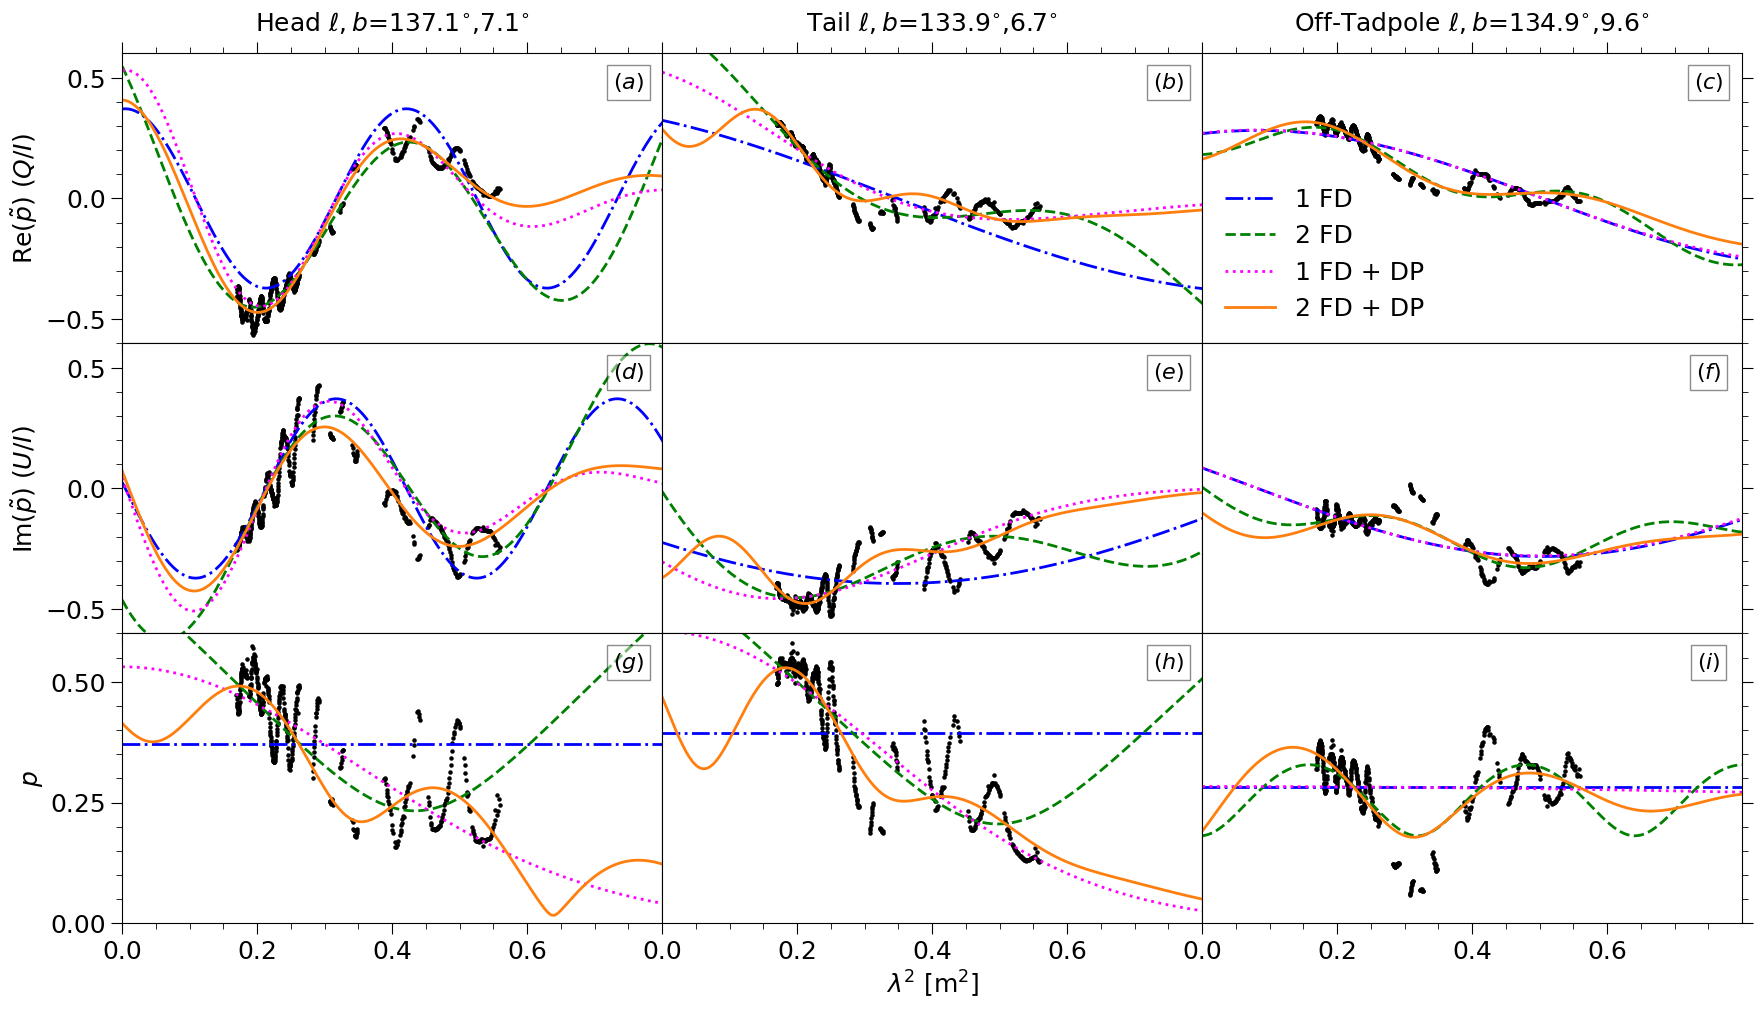

In [13]:
labels = ['1 FD','2 FD','1 FD + DP','2 FD + DP']
linestyles = ['-.','--',':','-']
models = ['m1','m11','m2','m4']
colors = ['blue','green','magenta','C1']

plot_QU_fit_result_paper(0,1,2,models,models,models,linestyles,colors,labels,legend=True)

## Make QU-fitting, Faraday synth comparison plots for Appendix B:

In [ ]:
plot_QU_fit_RMsynth_paper('Head',0)

In [ ]:
plot_QU_fit_RMsynth_paper('Tail',1)

In [ ]:
plot_QU_fit_RMsynth_paper('Off-Tadpole',2)

In [ ]:
print(params['m2'].keys())

## Print out QU-fitting results for Appendix B table

In [ ]:
i=2
m='m1'
#print('&',np.round(stats[m]['BIC'][i]/1e3,1),
#      '&',np.round(params[m]['fracPol'][i],1),
#      '&',np.round(params[m]['RM_radm2'][i],1),
#      '&',np.round(params[m]['psi0_deg'][i],1))

print('&',np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(stats['m4']['lnZ'][i]/1000,1)-np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(params[m]['fracPol'][i],1),
      '&',np.round(params[m]['RM_radm2'][i],1),
      '&',np.round(params[m]['psi0_deg'][i],1))


In [ ]:
i=2
m='m11'
#print('&',np.round(stats[m]['BIC'][i]/1e3,1),
#      '&',np.round(params[m]['fracPol1'][i],1),
#      '&',np.round(params[m]['RM1_radm2'][i],1),
#      '&',np.round(params[m]['psi01_deg'][i],1),
#      '&',np.round(params[m]['sigmaRM1_radm2'][i],1),
#      '&',np.round(params[m]['fracPol2'][i],1),
#      '&',np.round(params[m]['RM2_radm2'][i],1),
#      '&',np.round(params[m]['psi02_deg'][i],1),
#      '&',np.round(params[m]['sigmaRM2_radm2'][i],2))
print('&',np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(stats['m4']['lnZ'][i]/1000,1)-np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(params[m]['fracPol1'][i],1),
      '&',np.round(params[m]['RM1_radm2'][i],1),
      '&',np.round(params[m]['psi01_deg'][i],1),
      '&',np.round(params[m]['fracPol2'][i],1),
      '&',np.round(params[m]['RM2_radm2'][i],1),
      '&',np.round(params[m]['psi02_deg'][i],1))


In [ ]:
i=2
m='m2'
#print('&',np.round(stats[m]['BIC'][i]/1e3,1),
#      '&',np.round(params[m]['fracPol'][i],1),
#      '&',np.round(params[m]['RM_radm2'][i],1),
#      '&',np.round(params[m]['psi0_deg'][i],1),
#      '&',np.round(params[m]['sigmaRM_radm2'][i],2))

print('&',np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(stats['m4']['lnZ'][i]/1000,1)-np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(params[m]['fracPol'][i],1),
      '&',np.round(params[m]['RM_radm2'][i],1),
      '&',np.round(params[m]['psi0_deg'][i],1),
      '&',np.round(params[m]['sigmaRM_radm2'][i],2))

In [ ]:
i=2
m='m4'
#print('&',np.round(stats[m]['BIC'][i]/1e3,1),
#      '&',np.round(params[m]['fracPol1'][i],1),
#      '&',np.round(params[m]['RM1_radm2'][i],1),
#      '&',np.round(params[m]['psi01_deg'][i],1),
#      '&',np.round(params[m]['sigmaRM1_radm2'][i],1),
#      '&',np.round(params[m]['fracPol2'][i],1),
#      '&',np.round(params[m]['RM2_radm2'][i],1),
#      '&',np.round(params[m]['psi02_deg'][i],1),
#      '&',np.round(params[m]['sigmaRM2_radm2'][i],2))
print('&',np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(stats['m4']['lnZ'][i]/1000,1)-np.round(stats[m]['lnZ'][i]/1000,1),
      '&',np.round(params[m]['fracPol1'][i],1),
      '&',np.round(params[m]['RM1_radm2'][i],1),
      '&',np.round(params[m]['psi01_deg'][i],1),
      '&',np.round(params[m]['sigmaRM1_radm2'][i],2),
      '&',np.round(params[m]['fracPol2'][i],1),
      '&',np.round(params[m]['RM2_radm2'][i],1),
      '&',np.round(params[m]['psi02_deg'][i],1),
      '&',np.round(params[m]['sigmaRM2_radm2'][i],2))

## Print out QU fitting results for Table 2

In [ ]:
m='m4'
for i in range(0,3):
    print(np.round(lon[i],1),',',np.round(lat[i],1),
          '&',np.round(params[m]['fracPol1'][i],2),
          '&',np.round(params[m]['RM1_radm2'][i],1),
          '&',np.round(params[m]['psi01_deg'][i],0),
          '&',np.round(params[m]['sigmaRM1_radm2'][i],2),
          '&',np.round(params[m]['fracPol2'][i],2),
          '&',np.round(params[m]['RM2_radm2'][i],1),
          '&',np.round(params[m]['psi02_deg'][i],0),
          '&',np.round(params[m]['sigmaRM2_radm2'][i],2))

In [ ]:
# Old version
#Head & 137.1\arcdeg, 7.1\arcdeg & 0.41 & \bf{-7.9} &   7\arcdeg & 1.3  & 0.08 &   \bf{4.3} &  32\arcdeg  & 0.02
#Tail & 133.9\arcdeg, 6.7\arcdeg & 0.45 & \bf{-1.5} & 166\arcdeg & 1.2  & 0.17 & \bf{-12.4} & 112\arcdeg  & 2.1
#Off  & 134.9\arcdeg, 9.6\arcdeg & 0.25 & \bf{-1.3} & 175\arcdeg & 0.01 & 0.09 &   \bf{8.2} &  91\arcdeg  & 1.0

In [ ]:
# New version
#Head & 137.1\arcdeg, 7.1\arcdeg & 0.46 & \bf{-7.5} & 1\arcdeg & 1.4 & 0.08 & \bf{3.0} & 65\arcdeg & 0.02\\
#Tail & 133.9\arcdeg, 6.7\arcdeg & 0.47 & \bf{-1.4} & 163\arcdeg & 1.3 & 0.15 & \bf{-12.5} & 112\arcdeg & 2.0\\
#Off  & 134.9\arcdeg, 9.6\arcdeg & 0.26 & \bf{-1.3} & 176\arcdeg & 0.03 & 0.11 & \bf{7.4} & 106\arcdeg & 1.3\\

In [60]:
cat_pick = 3

print(np.nanmedian(stats['m1']['lnZ'][cat==cat_pick])/1e3)
print(np.nanmedian(stats['m11']['lnZ'][cat==cat_pick])/1e3)
print(np.nanmedian(stats['m2']['lnZ'][cat==cat_pick])/1e3)
print(np.nanmedian(stats['m4']['lnZ'][cat==cat_pick])/1e3)
print('')
print(np.nanmedian(params['m1']['RM_radm2'][cat==cat_pick]),np.nanstd(params['m1']['RM_radm2'][cat==cat_pick]))
print(np.nanmedian(params['m11']['RM1_radm2'][cat==cat_pick]),np.nanstd(params['m11']['RM1_radm2'][cat==cat_pick]))
print(np.nanmedian(params['m2']['RM_radm2'][cat==cat_pick]),np.nanstd(params['m2']['RM_radm2'][cat==cat_pick]))
print(np.nanmedian(params['m4']['RM1_radm2'][cat==cat_pick]),np.nanstd(params['m4']['RM1_radm2'][cat==cat_pick]))
print('')
print(np.nanmedian(params['m1']['fracPol'][cat==cat_pick]),np.nanstd(params['m1']['fracPol'][cat==cat_pick]))
print(np.nanmedian(params['m11']['fracPol1'][cat==cat_pick]),np.nanstd(params['m11']['fracPol1'][cat==cat_pick]))
print(np.nanmedian(params['m2']['fracPol'][cat==cat_pick]),np.nanstd(params['m2']['fracPol'][cat==cat_pick]))
print(np.nanmedian(params['m4']['fracPol1'][cat==cat_pick]),np.nanstd(params['m4']['fracPol1'][cat==cat_pick]))
print('')
print(np.nanmedian(params['m2']['sigmaRM_radm2'][cat==cat_pick]),np.nanstd(params['m2']['sigmaRM_radm2'][cat==cat_pick]))
print(np.nanmedian(params['m4']['sigmaRM1_radm2'][cat==cat_pick]),np.nanstd(params['m4']['sigmaRM1_radm2'][cat==cat_pick]))
print('')
print(np.nanmedian(params['m11']['RM2_radm2'][cat==cat_pick]),np.nanstd(params['m11']['RM2_radm2'][cat==cat_pick]))
print(np.nanmedian(params['m4']['RM2_radm2'][cat==cat_pick]),np.nanstd(params['m4']['RM2_radm2'][cat==cat_pick]))
print('')
print(np.nanmedian(params['m11']['fracPol2'][cat==cat_pick]),np.nanstd(params['m11']['fracPol2'][cat==cat_pick]))
print(np.nanmedian(params['m4']['fracPol2'][cat==cat_pick]),np.nanstd(params['m4']['fracPol2'][cat==cat_pick]))
print('')
print(np.nanmedian(params['m4']['sigmaRM2_radm2'][cat==cat_pick]),np.nanstd(params['m4']['sigmaRM2_radm2'][cat==cat_pick]))

-18.23541424791152
-12.00325684959471
-14.317779937149368
-10.566814867114019

-0.8085504057344863 0.5620947460503517
-0.7583349403975497 0.8929016035423643
-0.7604585318449004 0.750345979867856
-0.8235628245471673 0.6110756115381107

0.29088888366498994 0.056365236658278875
0.39461037578422953 0.15890283965812524
0.3642214869808496 0.11976376863108981
0.33358890253432216 0.10727509665712569

0.8120631840133168 0.7100544556853665
0.6382416331301947 0.6383822829658219

2.5512558006337542 8.08674062470587
8.87482526169292 11.087892025305118

0.08059399249591623 0.17074141308768576
0.060273655770039354 0.06899211170874454

1.3701291749853644 0.7249911130378351


In [48]:
print(cat[cat==1])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
